# CNN Emotion Detection

## 1. Load modules

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets

from torchinfo import summary

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torch import optim

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import cv2 as cv

from os import listdir, walk                  
from os.path import isfile, join

from tqdm.auto import tqdm

from pathlib import Path

from timeit import default_timer as timer


## 2. Load datasets

In [2]:
def walk_through_dir(dir_path: Path) -> dict:
    """Prints dir_path content"""
    counts = dict()
    classes = dict()
    i=-1
    for dirpath, dirnames, filenames in walk(dir_path):
        i = i+1
        print(f"There are {len(dirnames)} directiories and {len(filenames)} images in '{dirpath}' folder ")
        if (i>0):
            c = dirpath.split('\\')
            counts[c[-1]] = len(filenames)
            classes[c[-1]] = i
    return (counts, classes)

In [2]:
data_path = Path("Kaggle/CV/Emotions_detection")
images_path = data_path / "emotions_dataset"
train_path = images_path / "train"
test_path = images_path / "test"

ctrain, classes = walk_through_dir(train_path)
ctest, _ = walk_through_dir(test_path)

def make_datasets(counts, dataset_type):
    x = []
    y = []

    for label, count in counts.items():
        for i in range(0, count):
            img = cv.imread(f"Kaggle/CV/Emotions_detection/emotions_dataset/{dataset_type}/{label}/im{i}.png")
            img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            if type(img) is None:
                print("ALOOOOOOOO")
            x.append(img)
            y.append(label)

    x = np.array(x).astype(np.float32)
    return (torch.from_numpy(x), y)

x_train, y_tr = make_datasets(ctrain, "train")
x_test, y_te = make_datasets(ctest, "test")

print(len(x_train))
print(len(x_test))

print(classes)

def replace_label(y):
    y_new = [classes[label] for label in y]
    return torch.from_numpy(np.array(y_new))

y_train = replace_label(y_tr)
y_test  = replace_label(y_te)

print(y_train)

There are 7 directiories and 0 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\train' folder 
There are 0 directiories and 3995 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\train\angry' folder 
There are 0 directiories and 436 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\train\disgusted' folder 
There are 0 directiories and 4097 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\train\fearful' folder 
There are 0 directiories and 7215 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\train\happy' folder 
There are 0 directiories and 4965 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\train\neutral' folder 
There are 0 directiories and 4830 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\train\sad' folder 
There are 0 directiories and 3171 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\train\surprised' folder 
There are 7 directiories and 0 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test' folder 
Th

In [5]:
def make_dataloaders(images_path, batch_size):
    train_transform = transforms.Compose(
        [transforms.Resize(size=(224, 224)), 
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]
    )

    val_transform = transforms.Compose(
        [transforms.Resize(size=(224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]
    )

    train_dir = images_path / "train"
    val_dir = images_path / "test"

    train_data = datasets.ImageFolder(
        root=train_dir,
        transform=train_transform
    )

    val_data = datasets.ImageFolder(
        root=val_dir,
        transform=val_transform
    )

    BATCH_SIZE = batch_size

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )

    val_dataloader = DataLoader(
        dataset=val_data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4
    )
    return (train_dataloader, val_dataloader)
BATCH_SIZE = 8
#image_batch, label_batch = next(iter(train_dataloader))
#image_batch.shape, label_batch.shape

## 3. CNN Model

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


### 3.1 Network class

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(64, 256, 3)
        self.pool5 = nn.MaxPool2d(2, 2)


        self.fc1 = nn.Linear(6400, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)
summary(
    model=net,
    input_size=(BATCH_SIZE, 1, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Net (Net)                                [8, 1, 224, 224]     [8, 7]               --                   True
├─Conv2d (conv1)                         [8, 1, 224, 224]     [8, 3, 222, 222]     30                   True
├─MaxPool2d (pool1)                      [8, 3, 222, 222]     [8, 3, 111, 111]     --                   --
├─Conv2d (conv2)                         [8, 3, 111, 111]     [8, 16, 109, 109]    448                  True
├─MaxPool2d (pool2)                      [8, 16, 109, 109]    [8, 16, 54, 54]      --                   --
├─Conv2d (conv3)                         [8, 16, 54, 54]      [8, 32, 52, 52]      4,640                True
├─MaxPool2d (pool3)                      [8, 32, 52, 52]      [8, 32, 26, 26]      --                   --
├─Conv2d (conv4)                         [8, 32, 26, 26]      [8, 64, 24, 24]      18,496               True
├─MaxPool2d (pool4) 

### 3.3 Training

In [6]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device):

    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = torch.argmax(val_pred_logits, dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
            y_preds.append(val_pred_labels.cpu())

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    y_pred_tensor = torch.cat(y_preds)

    return val_loss, val_acc, y_pred_tensor


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device):
    results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        val_loss, val_acc, y_preds = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    print('Finished Training')
    return results, y_preds

In [7]:
def run_train(model, epochs, device, train_dataloader, val_dataloader):
    torch.cuda.manual_seed(42)
    torch.manual_seed(42)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=0.01
    )

    start_time = timer()

    model_results, preds = train(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=epochs,
        device=device
    )

    end_time = timer()
    print(f"Total learning time: {(end_time - start_time):.3f}")
    return (model_results, preds)

## 4. Testing

In [8]:
def test():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_dataloader:
            # images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')
    print(correct)
    print(total)


# # prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # again no gradients needed
# with torch.no_grad():
#     for data in val_dataloader:
#         images, labels = data
#         outputs = net(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1


# # print accuracy for each class
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## Running

In [34]:
net = Net()
net.to(device)


model_results, preds = run_train(net, 2, device, train_dataloader, val_dataloader)
test()

 50%|█████     | 1/2 [00:27<00:27, 27.67s/it]

Epoch: 0, Train loss: 1.814, Train acc: 0.250, Val loss: 1.815, Val acc: 0.247


100%|██████████| 2/2 [00:55<00:00, 27.57s/it]

Epoch: 1, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247
Finished Training
Total learning time: 55.143


Accuracy of the network on the test images: 24 %
1774
7178


## Visualizations

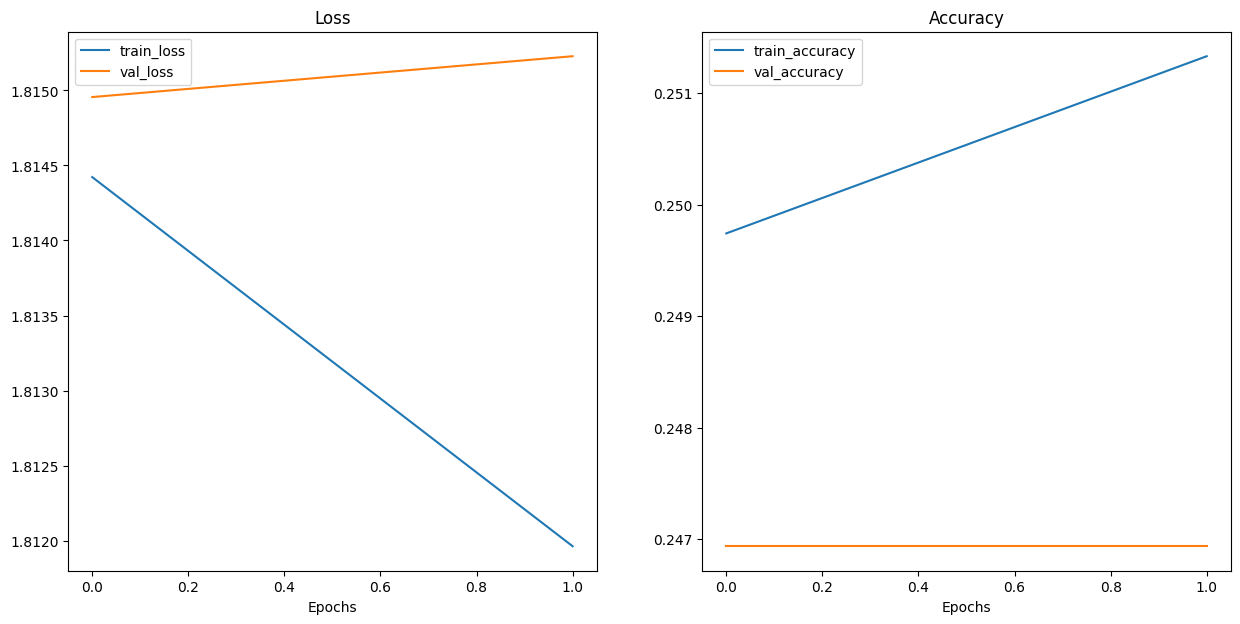

In [35]:
from typing import Tuple
from typing import Dict
from typing import List
import matplotlib.pyplot as plt

def plot_curves(results: Dict[str, List[float]]) -> None:
    """Plots loss and accuracy from a results dictionary."""

    train_loss = results["train_loss"]
    val_loss = results["val_loss"]

    train_accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_curves(model_results)

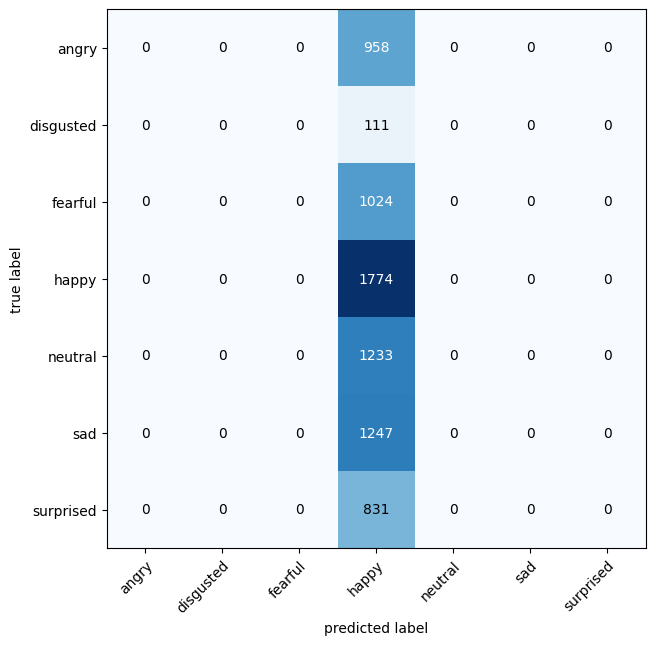

In [36]:
def draw_confusion_matrix(data: datasets.ImageFolder,
                          preds: torch.Tensor) -> None:

    confmat = ConfusionMatrix(num_classes=len(data.classes),task='multiclass')
    confmat_tensor = confmat(
        preds=preds,
        target=torch.ShortTensor(val_data.targets)
    )

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=data.classes,
        figsize=(10, 7))


draw_confusion_matrix(data=val_data,
                      preds=preds)

## Note to self

Uspeli smo da poboljsamo accuracy sa 1% na 17% tako sto smo stavili dodatne conv pool slojeve (od 2 na 5)

## CNN-2

In [44]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 24)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 16)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 6)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(64, 256, 3)
        self.pool5 = nn.MaxPool2d(2, 2)


        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 7)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net2()
net.to(device)

summary(
    model=net,
    input_size=(BATCH_SIZE, 1, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Net2 (Net2)                              [8, 1, 224, 224]     [8, 7]               --                   True
├─Conv2d (conv1)                         [8, 1, 224, 224]     [8, 3, 201, 201]     1,731                True
├─MaxPool2d (pool1)                      [8, 3, 201, 201]     [8, 3, 100, 100]     --                   --
├─Conv2d (conv2)                         [8, 3, 100, 100]     [8, 16, 85, 85]      12,304               True
├─MaxPool2d (pool2)                      [8, 16, 85, 85]      [8, 16, 42, 42]      --                   --
├─Conv2d (conv3)                         [8, 16, 42, 42]      [8, 32, 37, 37]      18,464               True
├─MaxPool2d (pool3)                      [8, 32, 37, 37]      [8, 32, 18, 18]      --                   --
├─Conv2d (conv4)                         [8, 32, 18, 18]      [8, 64, 16, 16]      18,496               True
├─MaxPool2d (pool4) 

In [45]:
net = Net2()
net.to(device)

model_results, preds = run_train(net, 2, device, train_dataloader, val_dataloader)
test()

 50%|█████     | 1/2 [00:50<00:50, 50.06s/it]

Epoch: 0, Train loss: 1.862, Train acc: 0.250, Val loss: 1.815, Val acc: 0.247


100%|██████████| 2/2 [01:39<00:00, 49.98s/it]

Epoch: 1, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247
Finished Training
Total learning time: 99.961


Accuracy of the network on the test images: 24 %
1774
7178


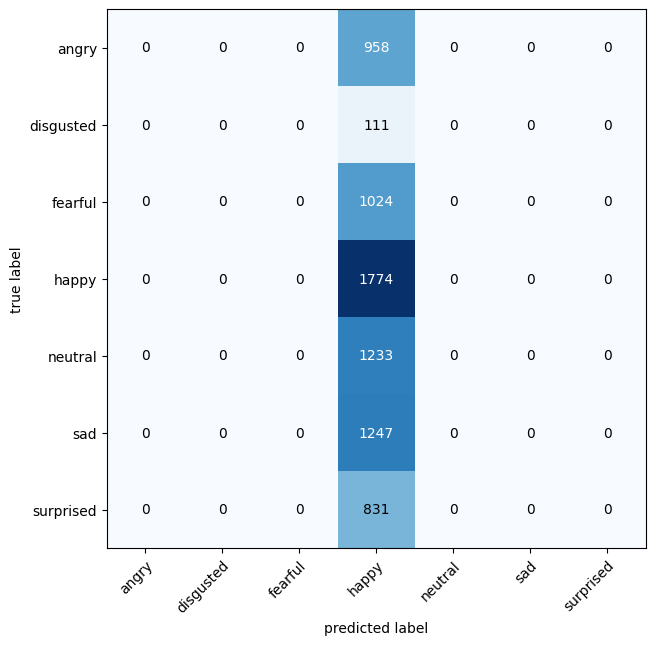

In [46]:
draw_confusion_matrix(data=val_data,
                      preds=preds)

  7%|▋         | 1/15 [00:49<11:38, 49.93s/it]

Epoch: 0, Train loss: 1.822, Train acc: 0.250, Val loss: 1.815, Val acc: 0.247


 13%|█▎        | 2/15 [01:39<10:46, 49.73s/it]

Epoch: 1, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247


 20%|██        | 3/15 [02:29<09:58, 49.87s/it]

Epoch: 2, Train loss: 1.812, Train acc: 0.251, Val loss: 1.816, Val acc: 0.247


 27%|██▋       | 4/15 [03:19<09:09, 50.00s/it]

Epoch: 3, Train loss: 1.812, Train acc: 0.251, Val loss: 1.817, Val acc: 0.247


 33%|███▎      | 5/15 [04:10<08:20, 50.10s/it]

Epoch: 4, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247


 40%|████      | 6/15 [04:59<07:30, 50.03s/it]

Epoch: 5, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247


 47%|████▋     | 7/15 [05:50<06:40, 50.07s/it]

Epoch: 6, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247


 53%|█████▎    | 8/15 [06:40<05:50, 50.12s/it]

Epoch: 7, Train loss: 1.812, Train acc: 0.251, Val loss: 1.816, Val acc: 0.247


 60%|██████    | 9/15 [07:30<05:00, 50.07s/it]

Epoch: 8, Train loss: 1.812, Train acc: 0.251, Val loss: 1.817, Val acc: 0.247


 67%|██████▋   | 10/15 [08:20<04:10, 50.07s/it]

Epoch: 9, Train loss: 1.812, Train acc: 0.251, Val loss: 1.818, Val acc: 0.247


 73%|███████▎  | 11/15 [09:10<03:20, 50.01s/it]

Epoch: 10, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247


 80%|████████  | 12/15 [10:00<02:30, 50.07s/it]

Epoch: 11, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247


 87%|████████▋ | 13/15 [10:50<01:40, 50.05s/it]

Epoch: 12, Train loss: 1.812, Train acc: 0.251, Val loss: 1.816, Val acc: 0.247


 93%|█████████▎| 14/15 [11:40<00:50, 50.08s/it]

Epoch: 13, Train loss: 1.812, Train acc: 0.251, Val loss: 1.818, Val acc: 0.247


100%|██████████| 15/15 [12:30<00:00, 50.04s/it]

Epoch: 14, Train loss: 1.812, Train acc: 0.251, Val loss: 1.816, Val acc: 0.247
Finished Training
Total learning time: 750.600


Accuracy of the network on the test images: 24 %
1774
7178


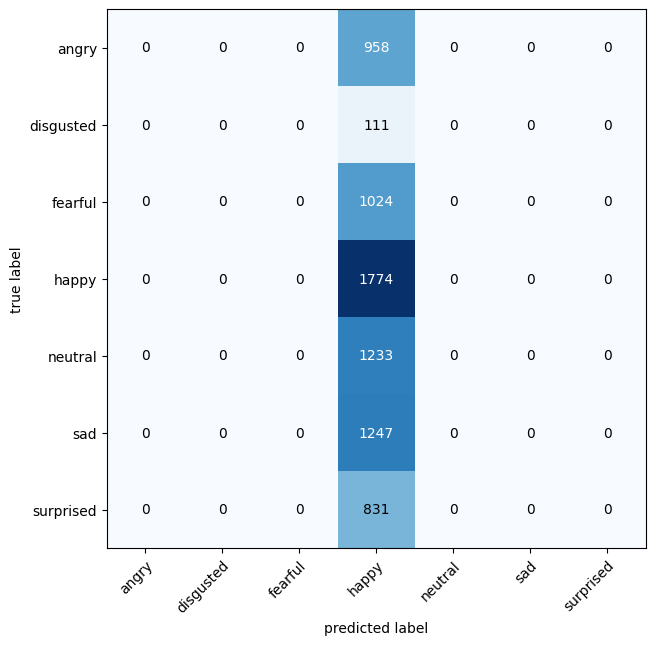

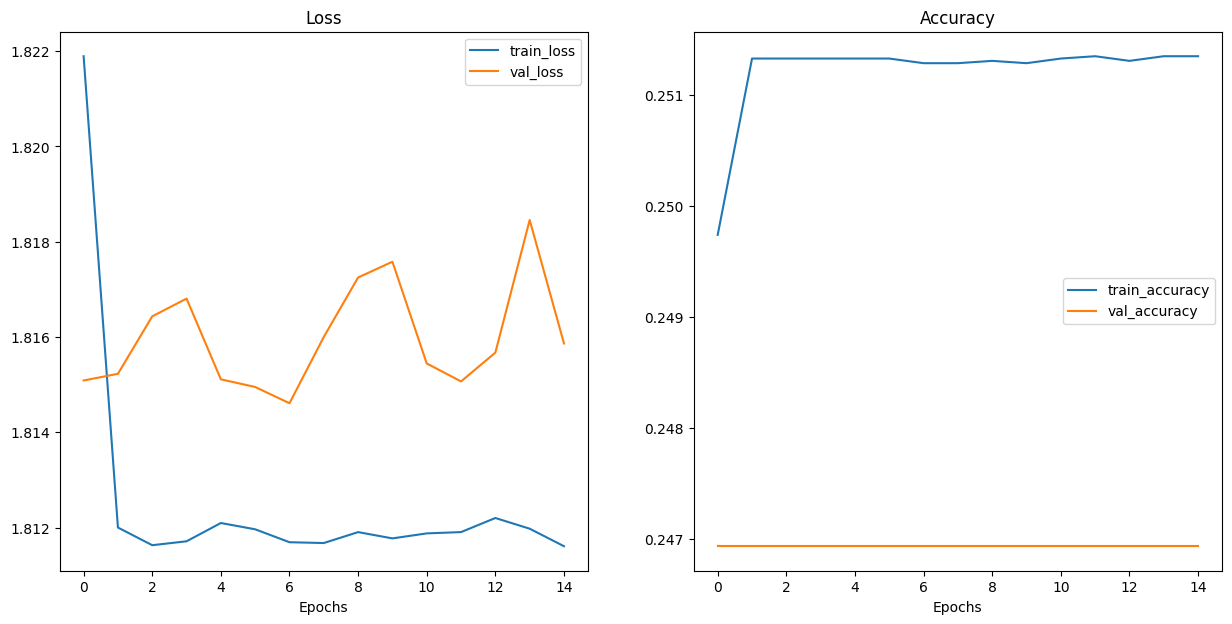

In [47]:
net = Net2()
net.to(device)

model_results, preds = run_train(net, 15, device, train_dataloader, val_dataloader)
test()
draw_confusion_matrix(data=val_data, preds=preds)
plot_curves(model_results)

# Upscaled dataset

In [10]:
data_path = Path("upscaled_images")
images_path = data_path 
train_path = images_path / "train"
test_path = images_path / "test"

ctrain, classes = walk_through_dir(train_path)
ctest, _ = walk_through_dir(test_path)

train_dataloader, val_dataloader = make_dataloaders(images_path, BATCH_SIZE)


There are 7 directiories and 0 images in 'upscaled_images\train' folder 
There are 0 directiories and 3995 images in 'upscaled_images\train\angry' folder 
There are 0 directiories and 436 images in 'upscaled_images\train\disgusted' folder 
There are 0 directiories and 4097 images in 'upscaled_images\train\fearful' folder 
There are 0 directiories and 7215 images in 'upscaled_images\train\happy' folder 
There are 0 directiories and 4965 images in 'upscaled_images\train\neutral' folder 
There are 0 directiories and 4830 images in 'upscaled_images\train\sad' folder 
There are 0 directiories and 3171 images in 'upscaled_images\train\surprised' folder 
There are 7 directiories and 0 images in 'upscaled_images\test' folder 
There are 0 directiories and 958 images in 'upscaled_images\test\angry' folder 
There are 0 directiories and 111 images in 'upscaled_images\test\disgusted' folder 
There are 0 directiories and 1024 images in 'upscaled_images\test\fearful' folder 
There are 0 directiories 

In [12]:
net = Net()
net.to(device)

model_results, preds = run_train(net, 15, device, train_dataloader, val_dataloader)
test()
draw_confusion_matrix(data=val_data, preds=preds)
plot_curves(model_results)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Train loss: 1.817, Train acc: 0.250, Val loss: 1.815, Val acc: 0.247
Epoch: 1, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247
Epoch: 2, Train loss: 1.812, Train acc: 0.251, Val loss: 1.816, Val acc: 0.247
Epoch: 3, Train loss: 1.812, Train acc: 0.251, Val loss: 1.817, Val acc: 0.247
Epoch: 4, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247
Epoch: 5, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247
Epoch: 6, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247
Epoch: 7, Train loss: 1.812, Train acc: 0.251, Val loss: 1.816, Val acc: 0.247
Epoch: 8, Train loss: 1.812, Train acc: 0.251, Val loss: 1.817, Val acc: 0.247
Epoch: 9, Train loss: 1.812, Train acc: 0.251, Val loss: 1.818, Val acc: 0.247
Epoch: 10, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247
Epoch: 11, Train loss: 1.812, Train acc: 0.251, Val loss: 1.815, Val acc: 0.247
Epoch: 12, Train loss: 1.812, Train acc: 0.251, Va

NameError: name 'draw_confusion_matrix' is not defined